In [1]:
from __future__ import print_function, division, absolute_import

import GPy
import numpy as np
import matplotlib as mpl
import stage_opt
import safeopt
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from utilities import (plot_2d_gp, plot_3d_gp, plot_contour_gp,
                        linearly_spaced_combinations, sample_gp_function)

mpl.rcParams['figure.figsize'] = (40.0, 10.0)
mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.markersize'] = 0.5

In [2]:
# # 设置输入安全限制数目n，则gp总数为n+1，第一个是效用函数
# safe_dim = 2

# # 设置测量不确定度，即可认为是误差方差
# noise_var = []

# # 设置kernel
# kernel = []
# for i in range(0, safe_dim + 1):
#     kernel.append(GPy.kern.RBF(input_dim=len(bounds), variance=2, lengthscale=1.0, ARD=True))
#     noise_var.append(0.005 ** 2)

# Measurement noise
noise_var = [0.05 ** 2, 1e-4, 1e-4]


# Bounds on the inputs variable
bounds = [(-10., 10.)]

# Define Kernel
kernel = GPy.kern.RBF(input_dim=len(bounds), variance=2., lengthscale=1.0, ARD=True)
kernel1 = kernel.copy()
kernel2 = kernel.copy()
kernel3 = kernel.copy()
kernel4 = kernel.copy()
kernel5 = kernel.copy()

# set of parameters
p_nums = 1000
parameter_set = linearly_spaced_combinations(bounds, p_nums)

# Initial safe point
index_0 = int(p_nums / 2)
x0 = np.zeros((1, len(bounds)))
x0[0][0] = parameter_set[index_0]

# Generate function with safe initial point at x=0
# 保证安全函数在给定点 parameter_set[500][:] 是安全的
def sample_safe_fun():
    fun = sample_gp_function(kernel, bounds, noise_var[0], 100)
    while True:
        fun2 = sample_gp_function(kernel1, bounds, noise_var[1], 100)
        if fun2(parameter_set[index_0][:], noise=False) > 1:
            break
    while True:
        fun3 = sample_gp_function(kernel2, bounds, noise_var[2], 100)
        if fun3(parameter_set[index_0][:], noise=False) > 1:
            break
            
    def combined_fun(x, noise=True):
        return np.hstack([fun(x, noise), fun2(x, noise), fun3(x, noise)])
    return combined_fun

In [3]:
# Define the objective function
fun = sample_safe_fun()

# # The statistical model of our objective function and safety constraint
y0 = fun(x0)

[0.01001001 0.01001001]
[0.01001001 0.01001001]
[0.01001001 0.01001001]


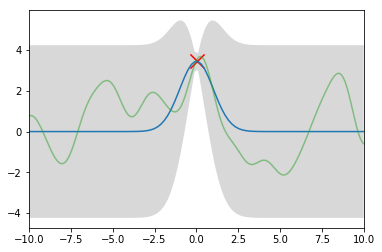

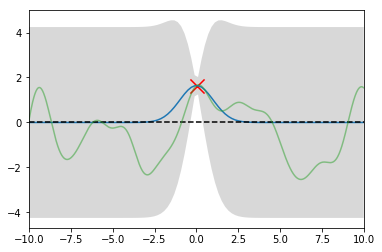

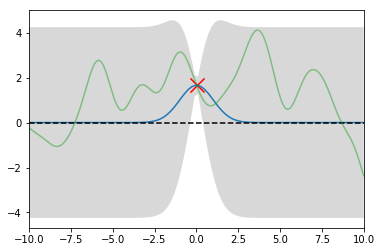

In [4]:

gp_stage = GPy.models.GPRegression(x0, y0[:, 0, None], kernel, noise_var=noise_var[0])
gp2_stage = GPy.models.GPRegression(x0, y0[:, 1, None], kernel1, noise_var=noise_var[1])
gp3_stage = GPy.models.GPRegression(x0, y0[:, 2, None], kernel2, noise_var=noise_var[2])

# The optimization routine
opt_stage = stage_opt.StageOpt([gp_stage, gp2_stage, gp3_stage],index_0, parameter_set, [-np.inf, 0., 0.], lipschitz=0.1, threshold=0.1)

def plot_stage(saferegion = None):
    # Plot the GP
    opt_stage.plot(100,saferegion)
    # Plot the true function
    y = fun(parameter_set, noise=False)
    for manager, true_y in zip(mpl._pylab_helpers.Gcf.get_all_fig_managers(), y.T):
        figure = manager.canvas.figure
        figure.gca().plot(parameter_set, true_y, color='C2', alpha=0.5)
    
plot_stage(opt_stage.bound)


[-0.87087087  4.51451451] 20 270
[-0.8908908908908906, 4.514514514514515]
[-0.8908908908908906, 4.514514514514515]
[-0.8908908908908906, 4.514514514514515]


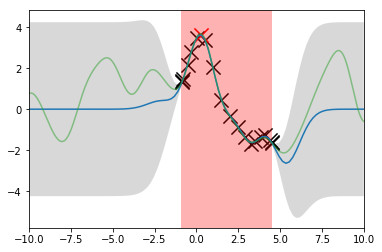

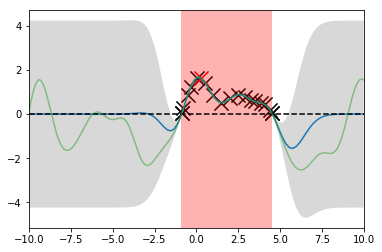

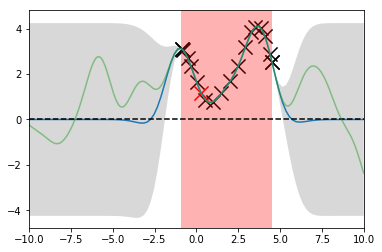

In [5]:
while opt_stage.t < 20:
    # Obtain next query point
    x_next = opt_stage.expansion()
    # Get a measurement from the real system
    y_meas = fun(x_next)
    # Add this to the GP model
    opt_stage.add_new_data_point(x_next, y_meas)
    # print(x_next,y_meas,np.sum(opt.G),opt.bound)
    if (y_meas[0][1] < 0) or (y_meas[0][2] < 0):
        print('error')
        break

a_stage = 0
b_stage = 0
for i in range(len(opt_stage.S) - 1):
    if ~opt_stage.S[i] and opt_stage.S[i+1]: 
        a_stage = i
    if opt_stage.S[i] and ~opt_stage.S[i+1]:
        b_stage = i
        break
        
print(opt_stage.bound,opt_stage.t,np.sum(opt_stage.S))
plot_stage([opt_stage.inputs[a_stage][0], opt_stage.inputs[b_stage][0]])

[-0.87087087  4.51451451]
[-0.87087087  4.51451451]
[-0.87087087  4.51451451]


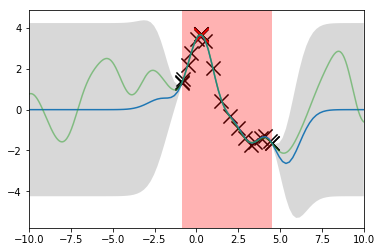

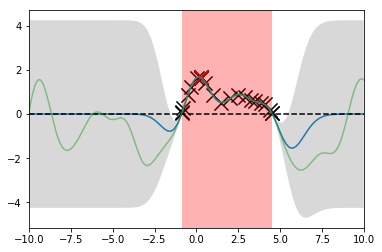

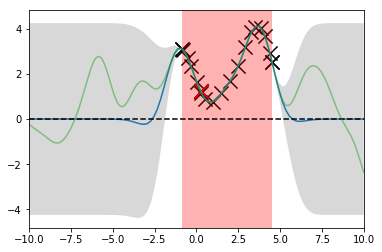

In [6]:
while opt_stage.t < 25:
    # Obtain next query point
    x_next = opt_stage.optimize()
    # Get a measurement from the real system
    y_meas = fun(x_next)
    # Add this to the GP model
    opt_stage.add_new_data_point(x_next, y_meas)
    # print(x_next,y_meas,np.sum(opt.G),opt.bound)
    if (y_meas[0][1] < 0) or (y_meas[0][2] < 0):
        print('error')
        break
        

stage_result = [x_next[0], y_meas[0][0]]
plot_stage(opt_stage.bound)
# print(np.min(opt.inputs(opt.S)), np.max(opt.inputs(opt.S)))

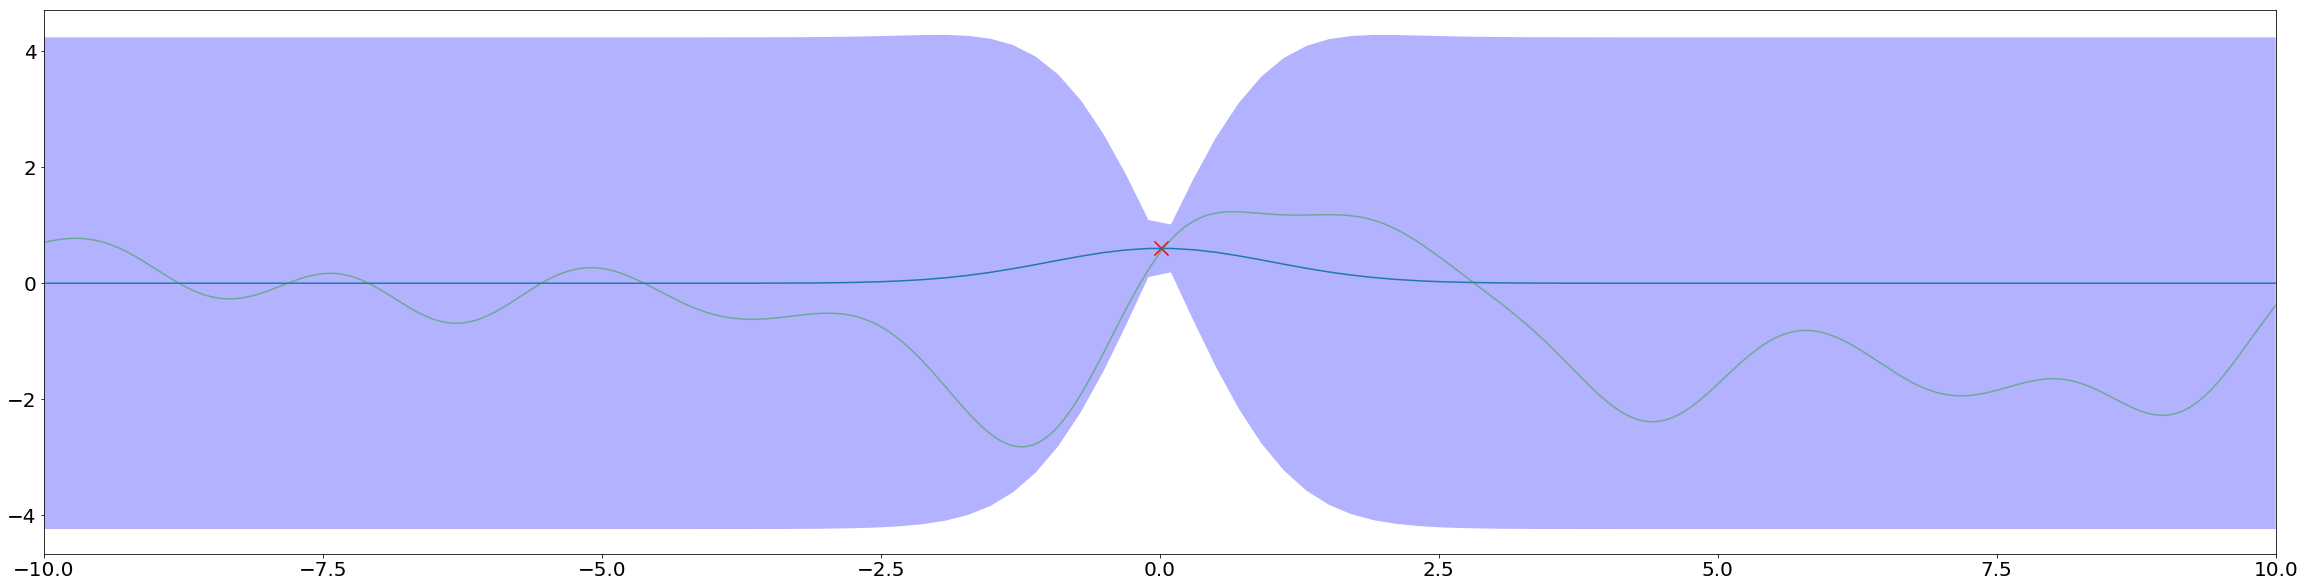

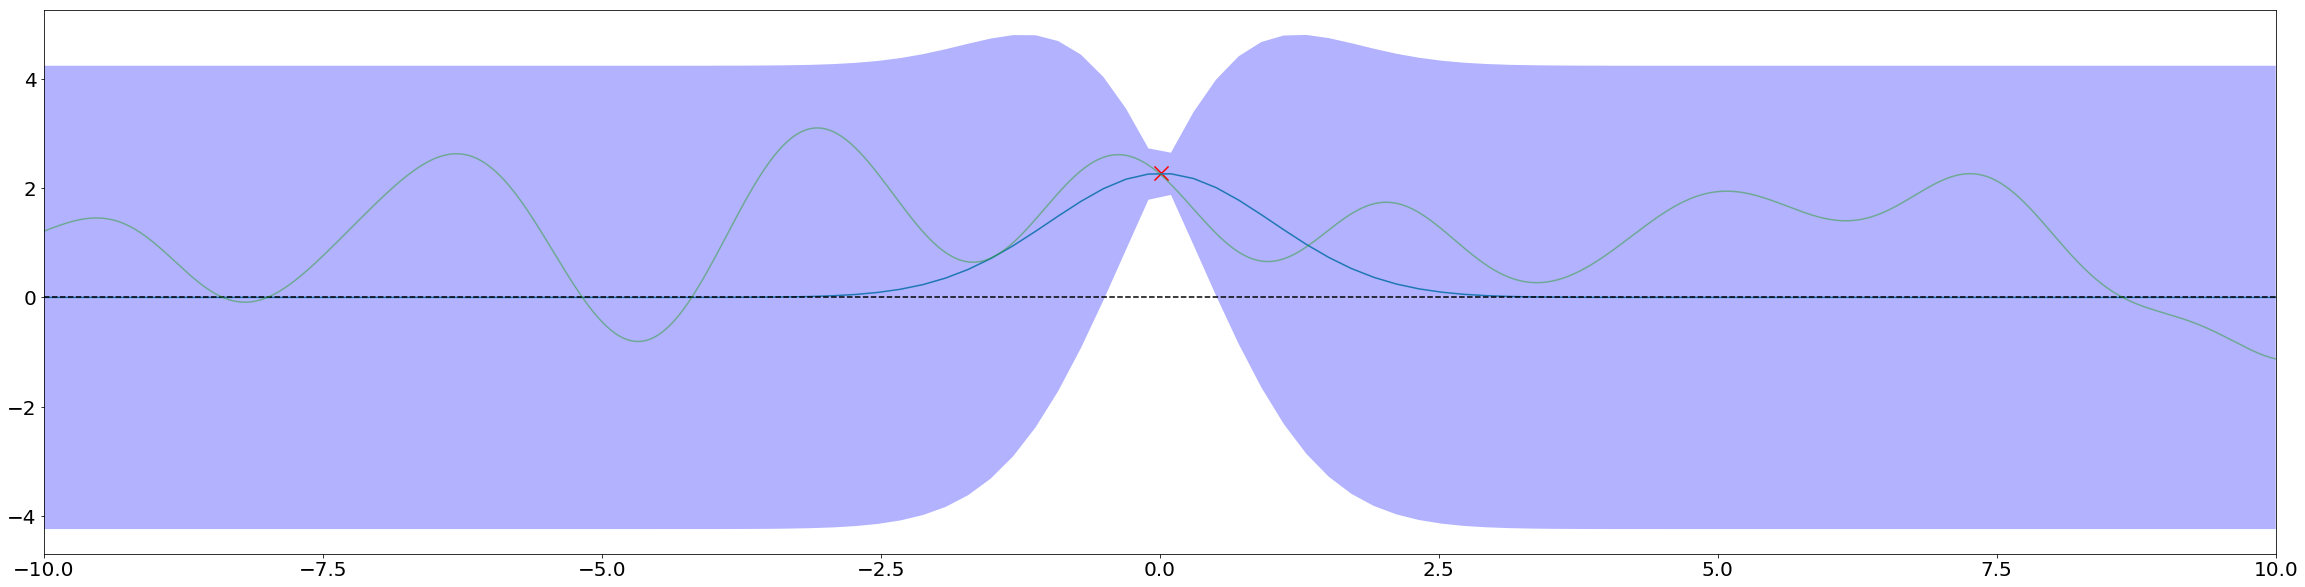

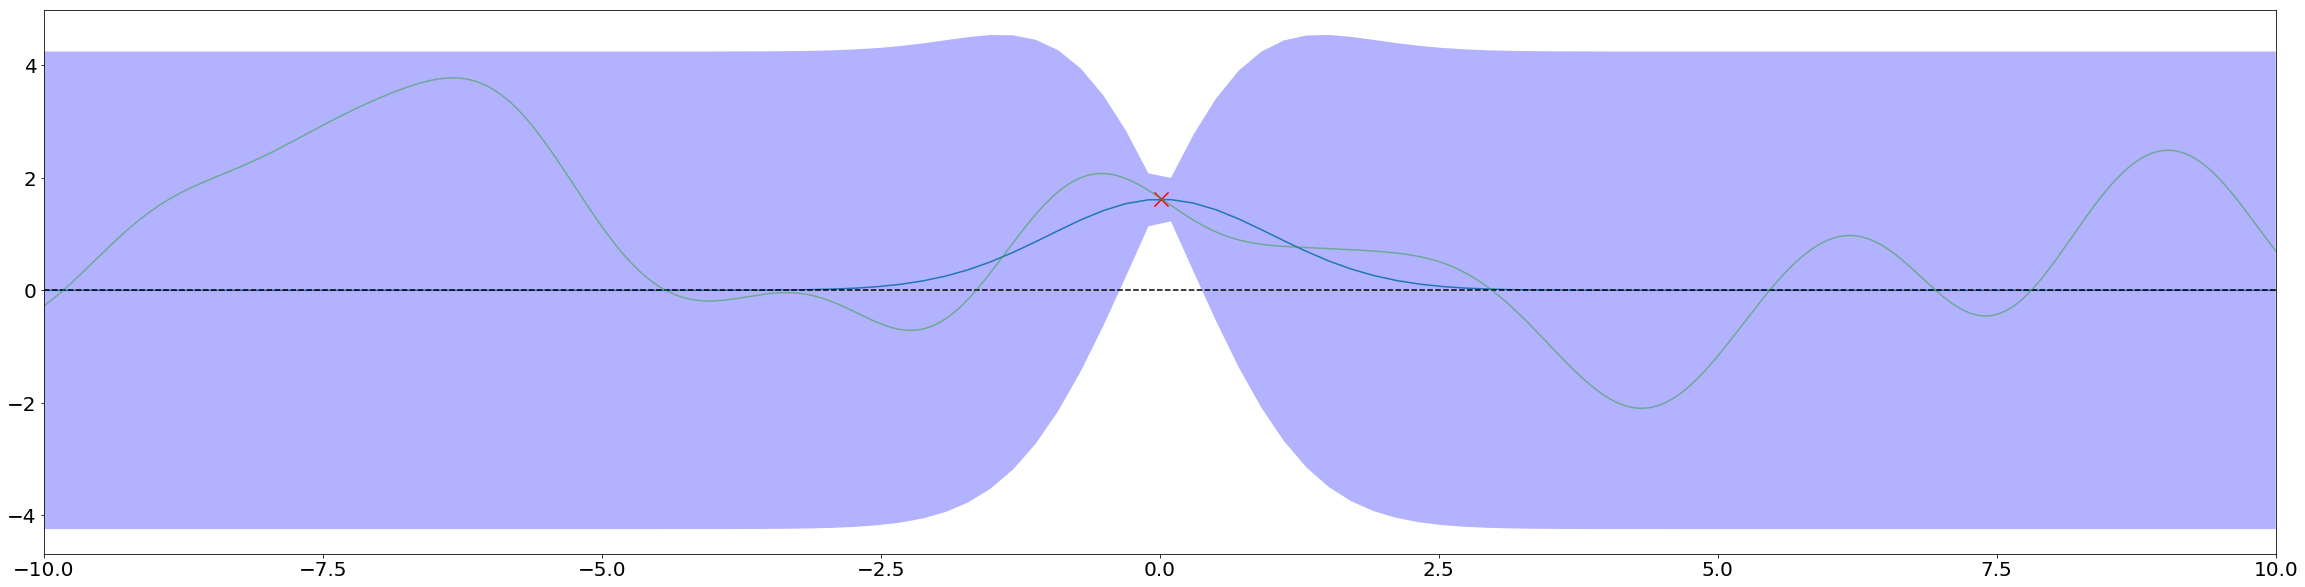

In [46]:

gp = GPy.models.GPRegression(x0, y0[:, 0, None], kernel, noise_var=noise_var[0])
gp2 = GPy.models.GPRegression(x0, y0[:, 1, None], kernel1, noise_var=noise_var[1])
gp3 = GPy.models.GPRegression(x0, y0[:, 2, None], kernel2, noise_var=noise_var[2])

# The optimization routine
# opt = safeopt.SafeOptSwarm([gp, gp2], [-np.inf, 0.], bounds=bounds, threshold=0.2)
opt = safeopt.SafeOpt([gp, gp2, gp3], parameter_set, [-np.inf, 0., 0.], lipschitz=0.1, threshold=1)

            
def plot(a = 0,b = 0):
    # Plot the GP
    opt.plot(100)
    # Plot the true function
    y = fun(parameter_set, noise=False)
    for manager, true_y in zip(mpl._pylab_helpers.Gcf.get_all_fig_managers(), y.T):
        if a != b:
            figure = manager.canvas.figure
            figure.gca().axvspan(a,b,facecolor='r',alpha=0.3)
        figure = manager.canvas.figure
        figure.gca().plot(parameter_set, true_y, color='C2', alpha=0.5)
    
plot()



22 198


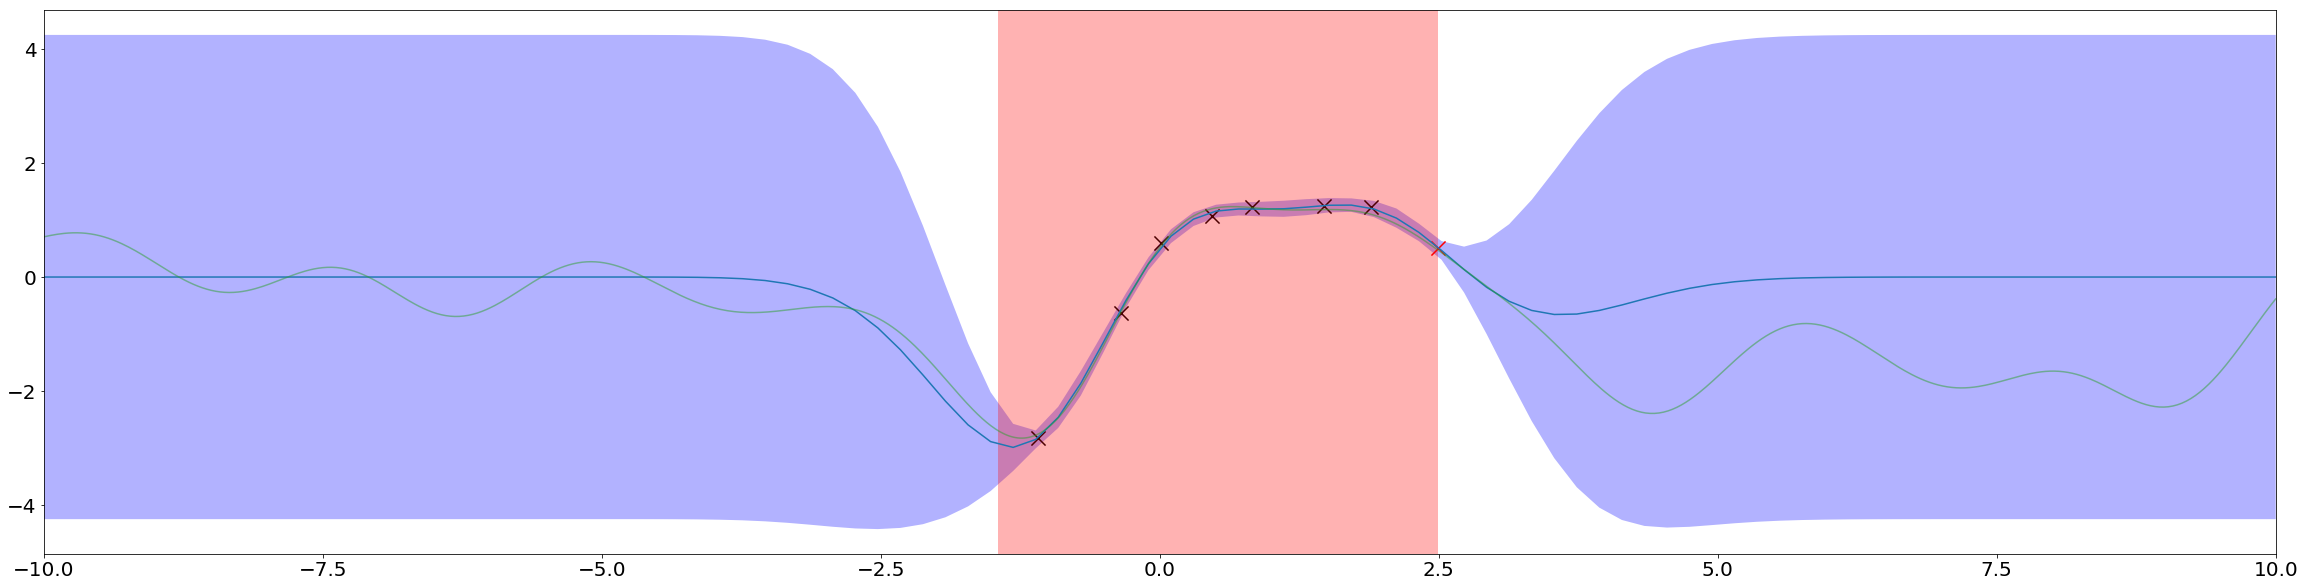

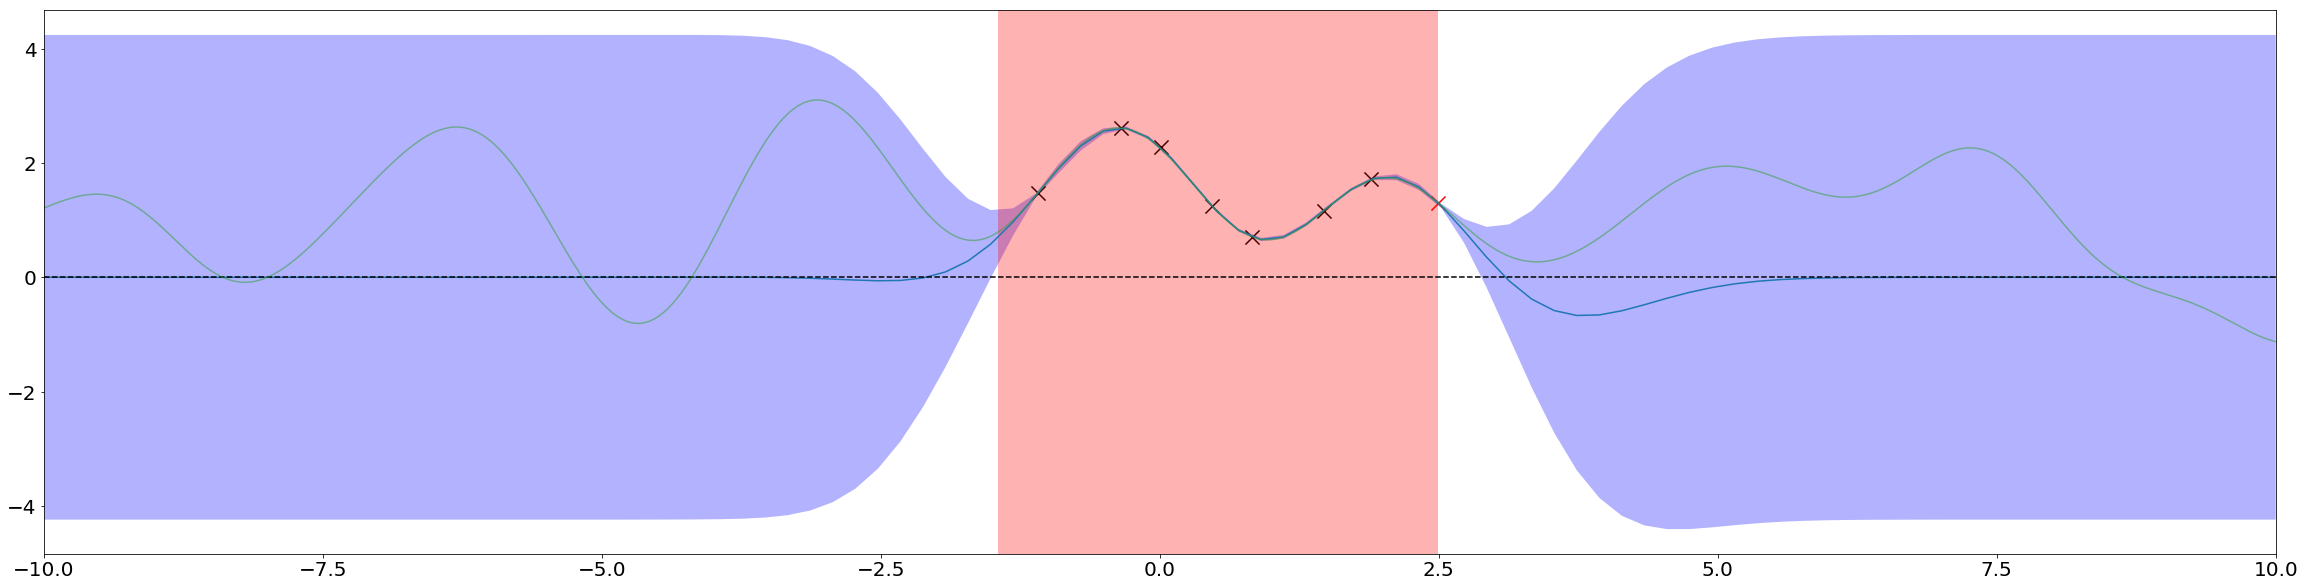

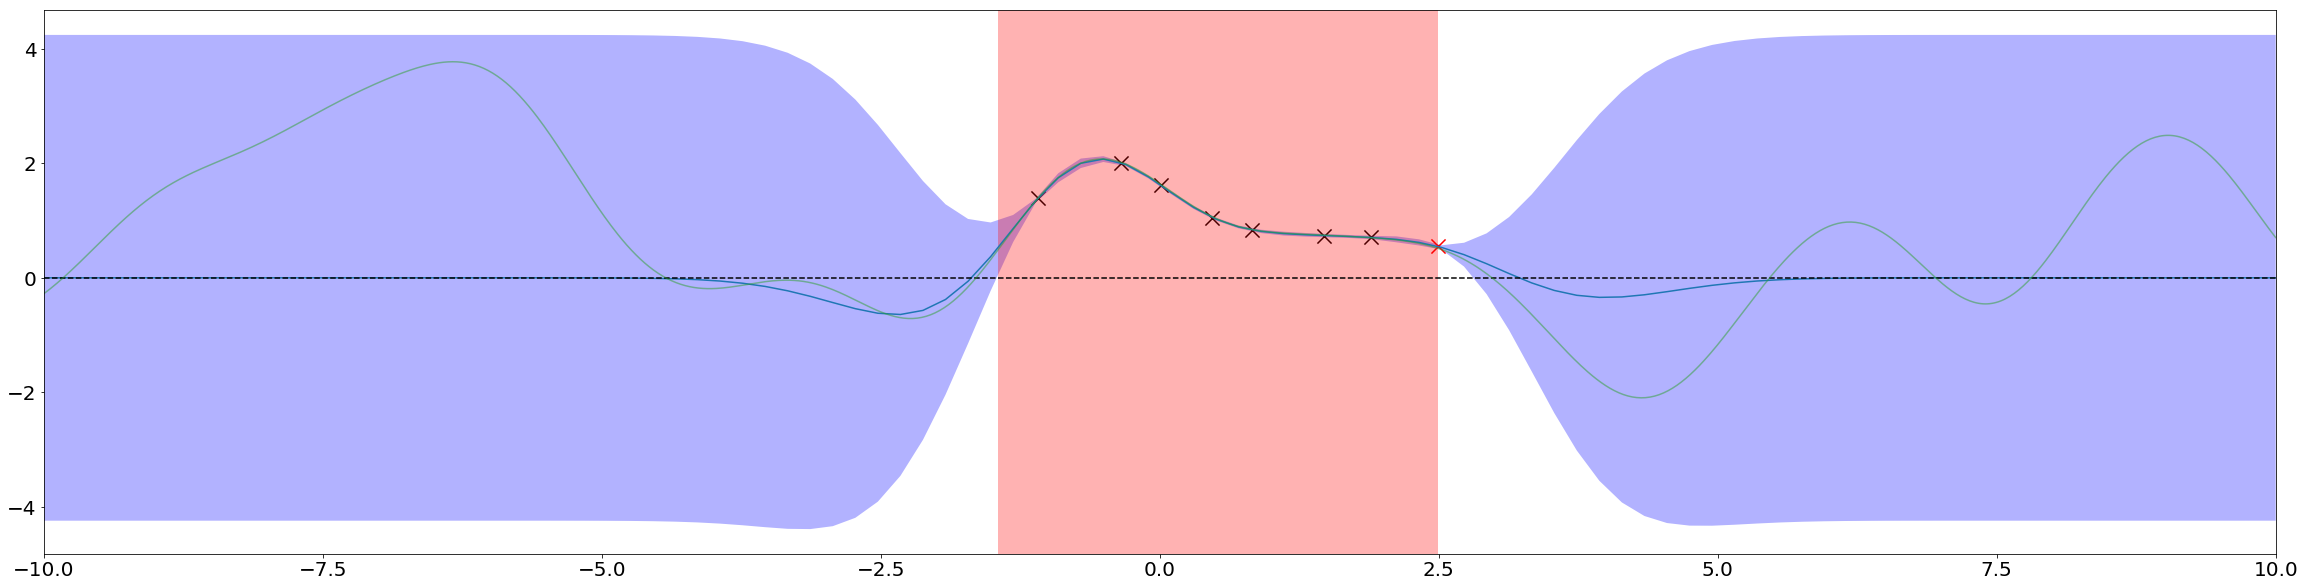

In [47]:
while opt.t < 20:
    # Obtain next query point
    x_next = opt.optimize()
    # Get a measurement from the real system
    y_meas = fun(x_next)
    # Add this to the GP model
    opt.add_new_data_point(x_next, y_meas)
    if (y_meas[0][1] < 0) or (y_meas[0][2] < 0):
        print('error')
        break
        
# print(np.min(opt.inputs(opt.S)), np.max(opt.inputs(opt.S)))
a = len(opt.S)
b = 0
for i in range(len(opt.S) - 1):
    if opt.S[i] and a > i:
        a = i
    if opt.S[i] and b < i:
        b = i;

print(opt.t,np.sum(opt.S))
plot(opt_stage.inputs[a][0], opt_stage.inputs[b][0])


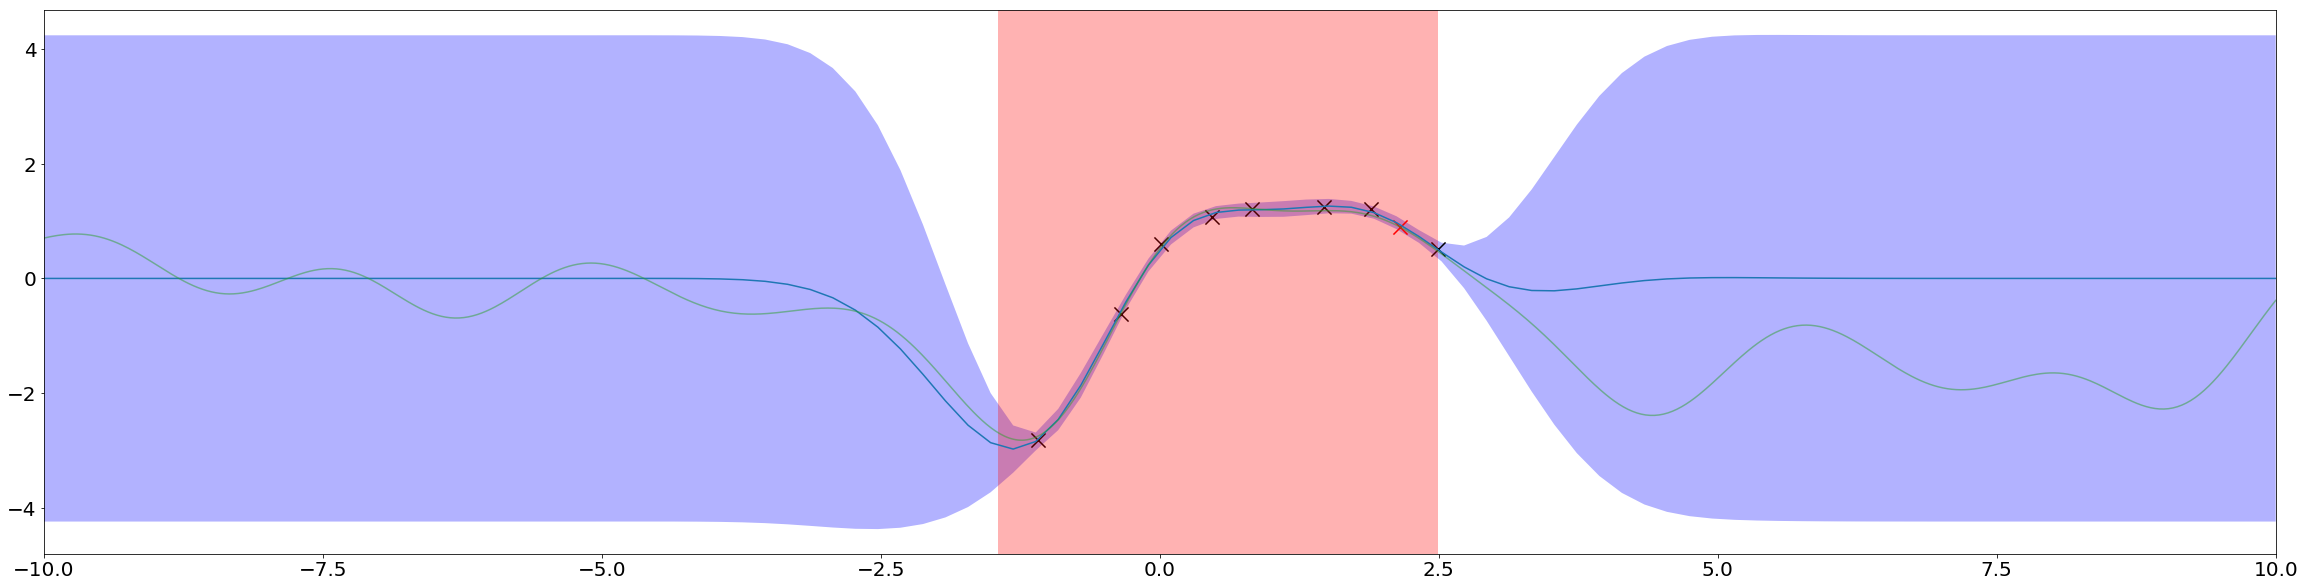

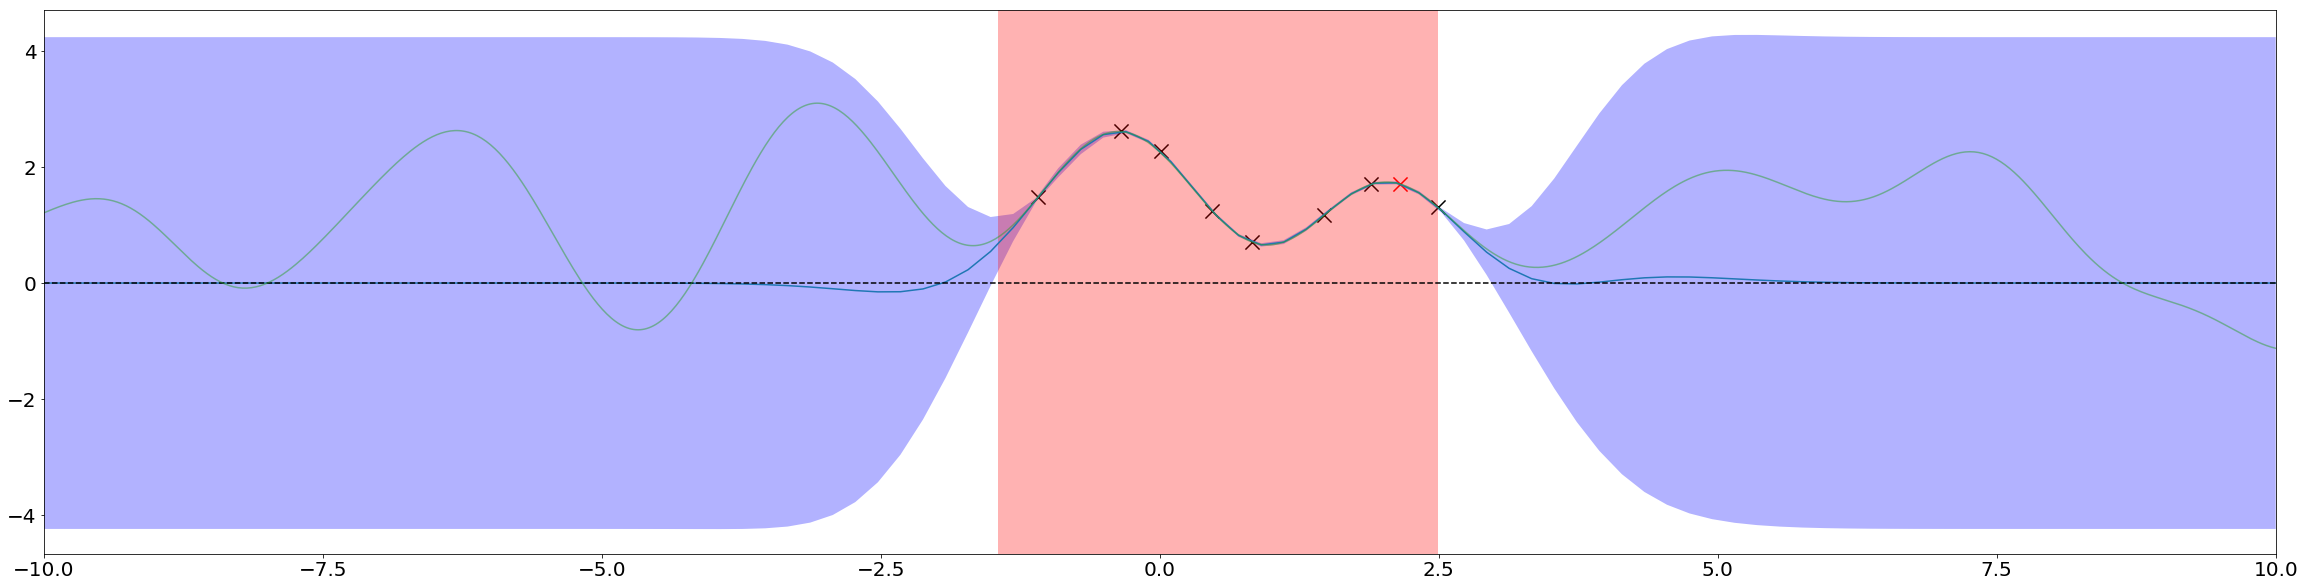

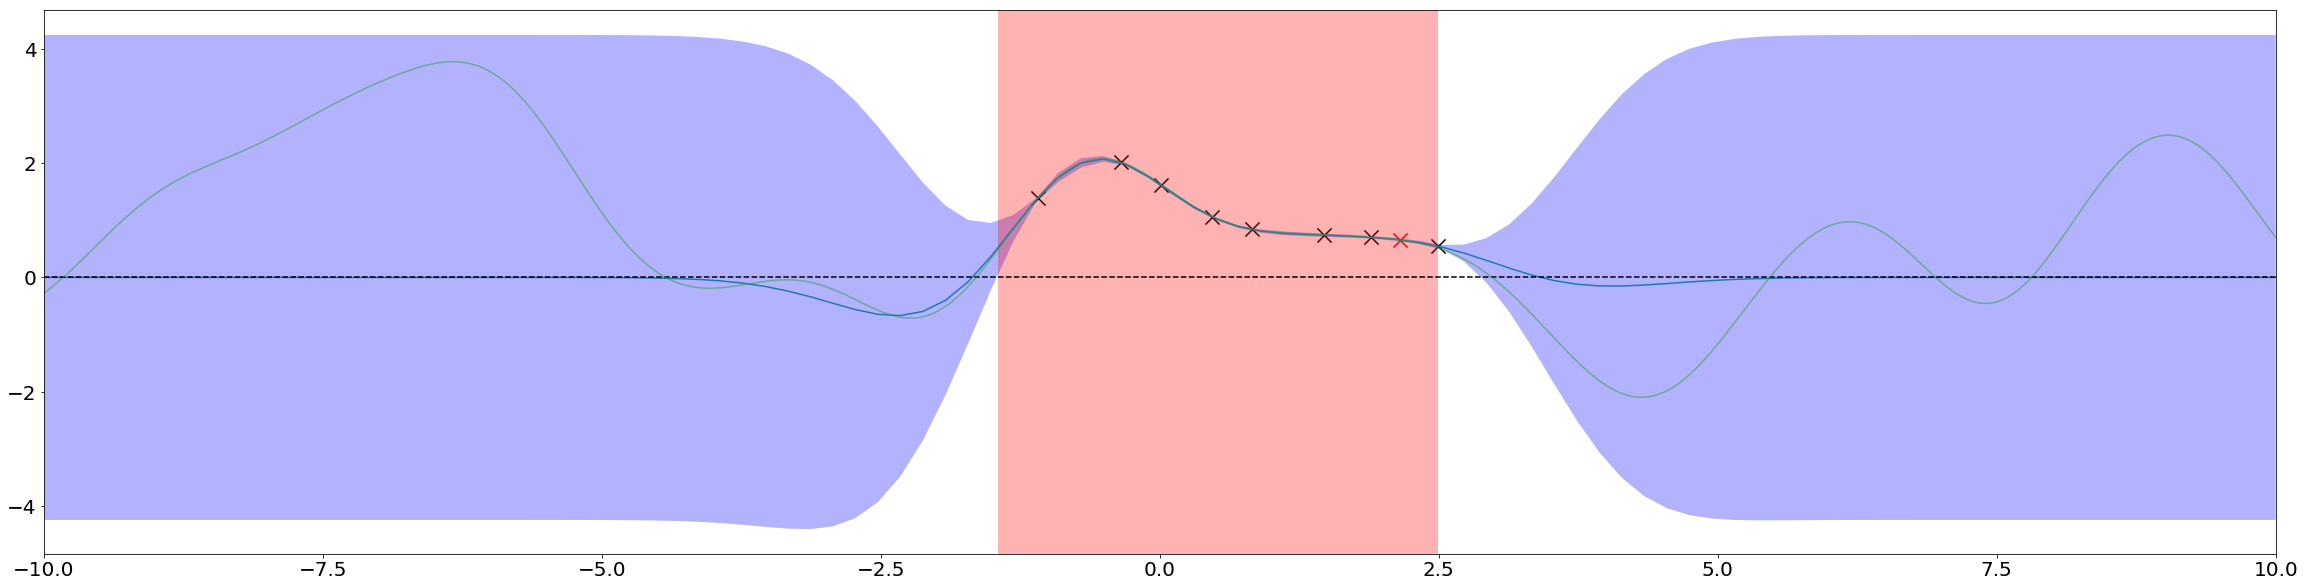

In [48]:
while opt.t < 25:
    # Obtain next query point
    x_next = opt.optimize()
    # Get a measurement from the real system
    y_meas = fun(x_next)
    # Add this to the GP model
    opt.add_new_data_point(x_next, y_meas)
    if (y_meas[0][1] < 0) or (y_meas[0][2] < 0):
        print('error')
        break

plot(opt_stage.inputs[a][0], opt_stage.inputs[b][0])
safe_result = [x_next[0], y_meas[0][0]]
        

In [49]:
print('stage_opt t_exp = 20 \t&\t safe_opt t = 20 ')
print('stage_opt safe region: \t[ ',opt_stage.inputs[a_stage][0],', ',opt_stage.inputs[b_stage][0],']')       
print('safe_opt safe region: \t[ ',opt.inputs[a][0],', ',opt.inputs[b][0],']\n')
print('stage_opt t_exp = 20, t_opt = 5 \t&\t safe_opt t = 25')
print('stage_opt result: \t x = ',stage_result[0],'\t y = ',stage_result[1])
print('safe_opt result: \t x = ' ,safe_result[0],'\t y = ',safe_result[1])

stage_opt t_exp = 20 	&	 safe_opt t = 20 
stage_opt safe region: 	[  -1.651651651651651 ,  2.9729729729729737 ]
safe_opt safe region: 	[  -1.451451451451451 ,  2.4924924924924916 ]

stage_opt t_exp = 20, t_opt = 5 	&	 safe_opt t = 25
stage_opt result: 	 x =  0.6306306306306304 	 y =  1.2483895765003303
safe_opt result: 	 x =  2.1521521521521514 	 y =  0.8940179941638939
